In [1]:
'''
1.CIFAR-10データセットを読み込み64×64にリサイズする
'''
from tensorflow.keras import datasets
import tensorflow as tf

(x_train, t_train), (x_test, t_test) = datasets.cifar10.load_data()
x_train = tf.image.resize(x_train, [64, 64])

In [2]:
'''
2.リサイズ後の訓練データの形状を出力
'''
x_train.shape

TensorShape([50000, 64, 64, 3])

In [3]:
'''
3.モデルの生成とコンパイル
'''
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers, regularizers

   
# VGG16モデルを学習済みの重みと共に読み込む
pre_trained_model = VGG16(
    include_top=False,      # 全結合層（FC）は読み込まない
    weights='imagenet',      # ImageNetで学習した重みを利用
    input_shape=(64, 64, 3)  # 入力データの形状
)

for layer in pre_trained_model.layers[:15]:
    # 第1～第15層までの重みを凍結
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    # 第16層以降の重みを更新可能にする
    layer.trainable = True

# Sequentualオブジェクトを生成
model = models.Sequential()

# VGG16モデルを追加
model.add(pre_trained_model)

# (batch_size, rows, cols, channels)の4階テンソルに
# プーリング演算適用後、(batch_size, channels)の2階テンソルにフラット化
model.add(
    layers.GlobalMaxPooling2D())

# 全結合層
model.add(
    layers.Dense(
        512,               # ユニット数512
        activation='relu') # 活性化関数はReLU
)
# 50%のドロップアウト
model.add(layers.Dropout(0.5))

# 出力層
model.add(
    layers.Dense(
        10,                    # ユニット数10
        activation='softmax') # 活性化関数はsoftmax
)

# モデルのコンパイル
model.compile(
    # 損失関数はスパースラベル対応クロスエントロピー誤差
    loss='sparse_categorical_crossentropy',
    # オプティマイザーはAdam
    optimizer=optimizers.Adam(lr=0.001),
    metrics=['accuracy'])

# コンパイル後のサマリを表示
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 7,347,210
Non-trainable params: 7,635,264
_________________________________________________________________


In [4]:
%%time
'''
4.転移学習を行う
'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import math

# ミニバッチのサイズ
batch_size = 64

# データ拡張
datagen = ImageDataGenerator(
    rescale=1.0/255.0,      # ピクセル値を255で割って正規化する
    validation_split=0.2,   # 20パーセントのデータを検証用にする
    rotation_range=15,      # 15度の範囲でランダムに回転させる
    width_shift_range=0.1,  # 横サイズの0.1の割合でランダムに水平移動
    height_shift_range=0.1, # 縦サイズの0.1の割合でランダムに垂直移動
    zoom_range=0.2,         # ランダムに拡大
)

# 訓練データ用のジェネレーターを生成
training_generator = datagen.flow(x_train, t_train,
                                  batch_size=batch_size,
                                  subset='training')      # 訓練用のデータを生成
# 検証データ用のジェネレーターを生成
validation_generator = datagen.flow(x_train, t_train,
                                    batch_size=batch_size,
                                    subset='validation') # 検証用のデータを生成

# 学習率をスケジューリングする
def step_decay(epoch):
    initial_lrate = 0.001 # 学習率の初期値
    drop = 0.5            # 減衰率は50%
    epochs_drop = 10.0    # 10エポック毎に減衰する
    lrate = initial_lrate * math.pow(
        drop,
        math.floor((epoch)/epochs_drop)
    )
    return lrate

# 学習率のコールバック
lrate = LearningRateScheduler(step_decay)

# ファインチューニングモデルで学習する
epochs = 50   # エポック数
history = model.fit(
    # 拡張データをミニバッチの数だけ生成
    training_generator,
    epochs=epochs,             # エポック数
    verbose=1,                 # 学習の進捗状況を出力する
    validation_data=validation_generator,
    # エポック終了後にlrateをコールバック
    # コールバックはリストで指定する
    callbacks=[lrate]
)

Train for 625 steps, validate for 157 steps
Epoch 1/50
625/625 [==============================] - 1796s 3s/step - loss: 1.5509 - accuracy: 0.4198 - val_loss: 0.9987 - val_accuracy: 0.6578
Epoch 2/50
625/625 [==============================] - 1865s 3s/step - loss: 0.8504 - accuracy: 0.7106 - val_loss: 0.7640 - val_accuracy: 0.7365
Epoch 3/50
625/625 [==============================] - 1855s 3s/step - loss: 0.7334 - accuracy: 0.7521 - val_loss: 0.7404 - val_accuracy: 0.7542
Epoch 4/50
625/625 [==============================] - 1898s 3s/step - loss: 0.6893 - accuracy: 0.7671 - val_loss: 0.7159 - val_accuracy: 0.7521
Epoch 5/50
625/625 [==============================] - 1858s 3s/step - loss: 0.6424 - accuracy: 0.7831 - val_loss: 0.7223 - val_accuracy: 0.7605
Epoch 6/50
625/625 [==============================] - 1919s 3s/step - loss: 0.6064 - accuracy: 0.7969 - val_loss: 0.7248 - val_accuracy: 0.7688
Epoch 7/50
625/625 [==============================] - 1886s 3s/step - loss: 0.5849 - accurac

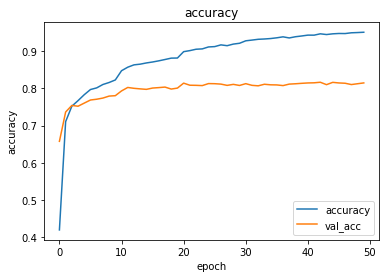

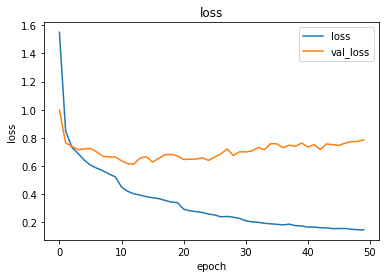

In [8]:
'''
4.損失と精度の推移をグラフにする
'''
%matplotlib inline
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # 精度の推移をプロット
    plt.plot(history.history['accuracy'],"-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"-",label="val_acc")
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の推移をプロット
    plt.plot(history.history['loss'],"-",label="loss",)
    plt.plot(history.history['val_loss'],"-",label="val_loss")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()
    
# 損失と精度をグラフに出力
plot_acc_loss(history)

In [15]:
'''
5. テストデータによるモデルの評価
'''
# テストデータをリサイズして正規化する
x_test = tf.image.resize(x_test, [64, 64])
x_test = x_test / 255.0

# 学習済みのモデルにテストデータを入力して損失と精度を取得
test_loss, test_acc = model.evaluate(x_test, t_test, verbose=0)
print('test_loss:', test_loss)
print('test_acc:', test_acc)

test_loss: 0.7038375641107559
test_acc: 0.8408
